In [2074]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

#df = pd.read_pickle('../daily/HQLS_full.pkl')

## Import 10 years of day closing data

In [2075]:
# df = df[['5. adjusted close', '6. volume']].tail(253 * 10)
# pd.set_option('display.max_rows', 100)
# df

In [2076]:
%matplotlib inline

# df.plot(y=["5. adjusted close"], figsize=(15, 4))
# df.plot(y=["6. volume"], figsize=(15, 4))

## Differentiation

In [2077]:
def differentiate(data):
#     print(data)
#     n = len(data)
#     print(n)
#     L = np.ptp(data) / 2
#     fhat = np.fft.fft(data)
#     kappa = (2 * np.pi / L) * np.arange(-n / 2, n / 2)
#     print(kappa)
#     kappa = np.fft.fftshift(kappa)
#     dfhat = kappa * fhat * (1j)
#     dfFFT = np.real(np.fft.ifft(dfhat))

#     return dfFFT.real
    return np.gradient(data)


def integrate(deri, init_data):
    from scipy import integrate
    return integrate.cumtrapz(y=deri) + init_data

# shift, diff, split and scale data

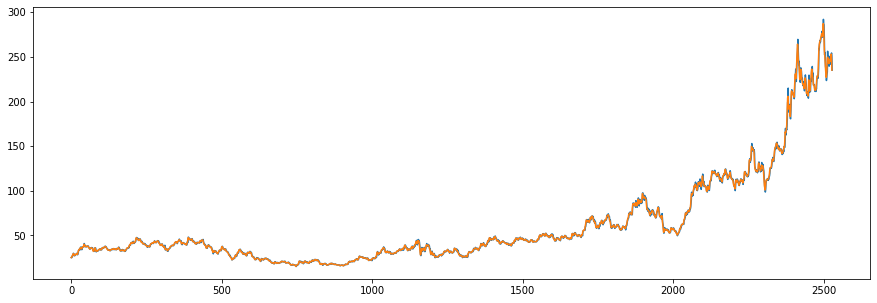

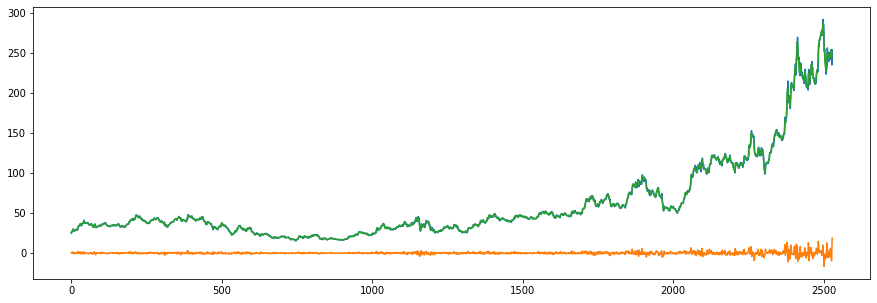

In [2078]:
target_data_file= '../daily/GJD_full.pkl'

df = pd.read_pickle(target_data_file)
df = df[['5. adjusted close', '6. volume']].tail(253 * 10)

days_shifted = 1    # shift by 1 trading days
df_targets = df.shift(-days_shifted)
df_targets

x_data = df.values[0:-days_shifted]
x_init_price = x_data[0,0]

# make sure the diff and integration are correct
plt.figure(figsize=(15,5))
plt.plot(x_data[:,0], label='true')

x_data[:,0] = differentiate(x_data[:,0])

ix = integrate(x_data[:,0],x_init_price)

plt.plot(ix, label='true')
plt.show()

plt.figure(figsize=(15,5))
y_data = df_targets[['5. adjusted close', '6. volume']]
y_data = y_data.values[0:-days_shifted]

plt.plot(y_data[:,0], label='true')
y_init_price = y_data[0,0]
y_data[:,0] = differentiate(y_data[:,0])
iy = integrate(y_data[:,0],y_init_price)
plt.plot(y_data[:,0], label='true')
plt.plot(iy, label='true')
plt.show()

In [2079]:
train_split = 0.9
num_total = x_data.shape[0]
num_train = int(train_split * num_total)
num_test = num_total - num_train

print(num_total, num_train, num_test)

2529 2276 253


In [2080]:
# min and max
print(np.min(x_data[:,0]))
print(np.max(x_data[:,0]))

-16.665001000000004
14.795005500000002


In [2081]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
y_train = y_data[0:num_train]
y_test = y_data[num_train:]

x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

num_x_signals = x_data.shape[1]
num_y_signals = y_data.shape[1]
print(num_x_signals)
print(num_y_signals)

2
2


## Batch Generator

In [2082]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)
        
batch_size = 1

sequence_length = 90 # days
sequence_length

generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

x_batch, y_batch = next(generator)

print(x_batch.shape)
print(y_batch.shape)

(1, 90, 2)
(1, 90, 2)


# Network

In [2083]:
model_name = 'GJD_10_year_1day_wvol'

model = Sequential()

model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

model.add(Dense(num_y_signals, activation='sigmoid'))

# from tensorflow.python.keras.initializers import RandomUniform

# # Maybe use lower init-ranges.
# init = RandomUniform(minval=-0.4, maxval=0.4)

# model.add(Dense(num_y_signals,
#                 activation='linear',
#                 kernel_initializer=init))

In [2084]:
warmup_steps = 5

def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [2085]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_66 (GRU)                 (None, None, 512)         792576    
_________________________________________________________________
dense_65 (Dense)             (None, None, 2)           1026      
Total params: 793,602
Trainable params: 793,602
Non-trainable params: 0
_________________________________________________________________


In [2086]:
path_checkpoint = model_name + '_checkpoint.keras'

callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./aapl_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [2087]:
%%time
model.fit(x=generator,
          epochs=15,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/15
100/100 [==============================] - 8s 53ms/step - loss: 0.0149 - val_loss: 0.0444

Epoch 00001: val_loss improved from inf to 0.04439, saving model to GJD_10_year_1day_wvol_checkpoint.keras
Epoch 2/15
100/100 [==============================] - 4s 39ms/step - loss: 0.0064 - val_loss: 0.0352

Epoch 00002: val_loss improved from 0.04439 to 0.03523, saving model to GJD_10_year_1day_wvol_checkpoint.keras
Epoch 3/15
100/100 [==============================] - 4s 39ms/step - loss: 0.0054 - val_loss: 0.0328

Epoch 00003: val_loss improved from 0.03523 to 0.03278, saving model to GJD_10_year_1day_wvol_checkpoint.keras
Epoch 4/15
100/100 [==============================] - 4s 41ms/step - loss: 0.0049 - val_loss: 0.0289

Epoch 00004: val_loss improved from 0.03278 to 0.02894, saving model to GJD_10_year_1day_wvol_checkpoint.keras
Epoch 5/15
100/100 [==============================] - 4s 40ms/step - loss: 0.0040 - val_loss: 0.0259

Epoch 00005: val_loss improved from 0.02894 to 0.0

In [2088]:
loaded_model = path_checkpoint
try:
    model.load_weights(loaded_model)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [2089]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

print("loss (test-set):", result)


1/1 [==============================] - 0s 33ms/step - loss: 0.0240
loss (test-set): 0.023970404639840126


## Evaluations

In [2090]:
# import matplotlib.pyplot as plt

# target_names = ["5. adjusted close"]

# def plot_comparison(start_idx, length=100, train=True):
#     """
#     Plot the predicted and true output-signals.
    
#     :param start_idx: Start-index for the time-series.
#     :param length: Sequence-length to process and plot.
#     :param train: Boolean whether to use training- or test-set.
#     """
    
#     if train:
#         # Use training-data.
#         x = x_train_scaled
#         y_true = y_train
#     else:
#         # Use test-data.
#         x = x_test_scaled
#         y_true = y_test
    
#     # End-index for the sequences.
#     end_idx = start_idx + length
    
#     # Select the sequences from the given start-index and
#     # of the given length.
#     x = x[start_idx:end_idx]
#     y_true = y_true[start_idx:end_idx]
    
#     # Input-signals for the model.
#     x = np.expand_dims(x, axis=0)

#     # Use the model to predict the output-signals.
#     y_pred = model.predict(x)
    
#     # The output of the model is between 0 and 1.
#     # Do an inverse map to get it back to the scale
#     # of the original data-set.
#     y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
#     # For each output-signal.
#     for signal in range(len(target_names)):
#         # Get the output-signal predicted by the model.
#         signal_pred = y_pred_rescaled[:, signal]
        
#         # Get the true output-signal from the data-set.
#         signal_true = y_true[:, signal]

#         # Make the plotting-canvas bigger.
#         plt.figure(figsize=(15,5))
        
#         # Plot and compare the two signals.
#         plt.plot(signal_true, label='true')
#         plt.plot(signal_pred, label='pred')
        
#         # Plot grey box for warmup-period.
#         p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
#         # Plot labels etc.
#         plt.ylabel(target_names[signal])
#         plt.legend()
#         plt.show()

In [2091]:
#plot_comparison(start_idx=0, length=5000, train=False)
# df = pd.read_pickle('../daily/GJD_full.pkl')
# df = df[['5. adjusted close', '6. volume']].tail(253 * 10)
# pd.set_option('display.max_rows', 100)
# df

In [2092]:
def predict_plot_compare(start_idx, length, x, y_true, scaler, dates, init_price, shift, filename):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x_whole = x.copy()
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)
    x_whole = np.expand_dims(x_whole, axis=0)


    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    y_pred_whole = model.predict(x_whole)
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = scaler.inverse_transform(y_pred[0])
    y_pred_whole_rescaled = scaler.inverse_transform(y_pred_whole[0])

#     print(y_pred_rescaled.shape)
#     print(iy.shape)

    # add date label
    dates_labels = dates
    
    plt.figure(figsize=(15,5))
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        #signal_pred = iy
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        #plt.plot(signal_pred, label='pred')
        plt.plot(y_pred_rescaled[:,0], label='pred')

        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        #plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()
        break
        
    # second plot
    final_df = pd.read_pickle(filename)
    final_df = final_df[['5. adjusted close', '6. volume']].tail(253 * 10)
    #iy = integrate(y_pred_rescaled[:,0], final_df["5. adjusted close"].values[start_idx])
    iy = y_pred_rescaled[:,0] + final_df["5. adjusted close"].values[start_idx:end_idx]
    #iy = np.insert(iy, 0, -1)
    plt.figure(figsize=(15,5))
    plt.plot(final_df["5. adjusted close"].values[start_idx:end_idx],label='true')
    x_pos = range(len(iy)+shift)[shift:]
    plt.plot(x_pos, iy,label='pred')
    plt.legend()
    plt.show
        
    print("last day with actual price is: " + str(dates_labels[-1]) + ' at: ' + str(final_df["5. adjusted close"].values[start_idx:end_idx][-1]))
    print("close price for next day is predicted to be: " + str(iy[-shift:]))
        
    return y_true, y_pred_whole_rescaled

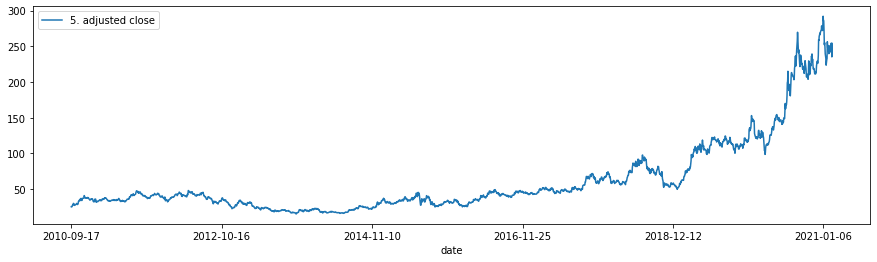

In [2093]:

ms_df = pd.read_pickle(target_data_file)
ms_df = ms_df[['5. adjusted close', '6. volume']].tail(253 * 10)

ms_df_original = pd.read_pickle(target_data_file)
ms_df_original = ms_df_original[['5. adjusted close', '6. volume']].tail(253 * 10)

ms_df.plot(y=["5. adjusted close"], figsize=(15, 4))

<Figure size 1080x360 with 0 Axes>

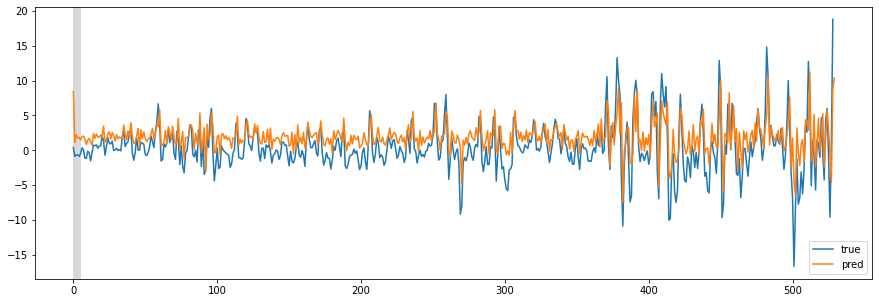

last day with actual price is: 2021-02-23 at: 253.880005
close price for next day is predicted to be: [264.28132927]


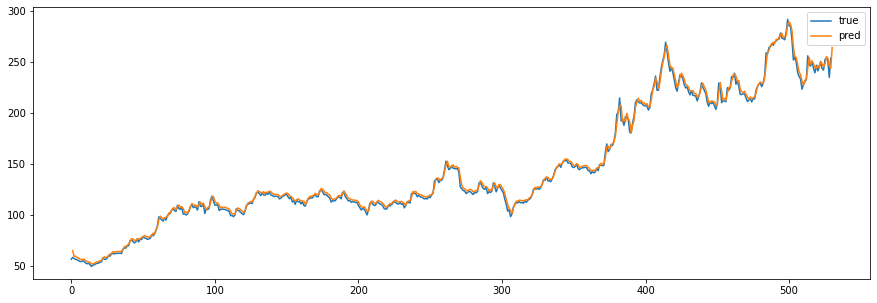

In [2094]:
dates = ms_df.index.values

ms_x_data = ms_df.values
ms_init_price = ms_x_data[0,0]

ms_x_data[:,0] = differentiate(ms_x_data[:,0])
ms_x_scaler = MinMaxScaler()
ms_x_scaled = ms_x_scaler.fit_transform(ms_x_data)

ms_df_targets = ms_df_original.shift(-days_shifted)
ms_y_data = ms_df_targets[['5. adjusted close']]
ms_y_data = ms_y_data.values[0:-days_shifted]
ms_y_data[:,0] = differentiate(ms_y_data[:,0])

ms_y_scaler = MinMaxScaler()
y_scaled = ms_y_scaler.fit_transform(ms_y_data)

# print(len(dates)) #assert
# print(len(ms_x_data))
# print(len(ms_y_data))


true, pred = predict_plot_compare(start_idx=2000, length=5000, x=ms_x_scaled, y_true=ms_y_data, 
                                  scaler=ms_y_scaler, dates=dates, init_price=ms_init_price, 
                                  shift=days_shifted, filename=target_data_file)

<Figure size 1080x360 with 0 Axes>

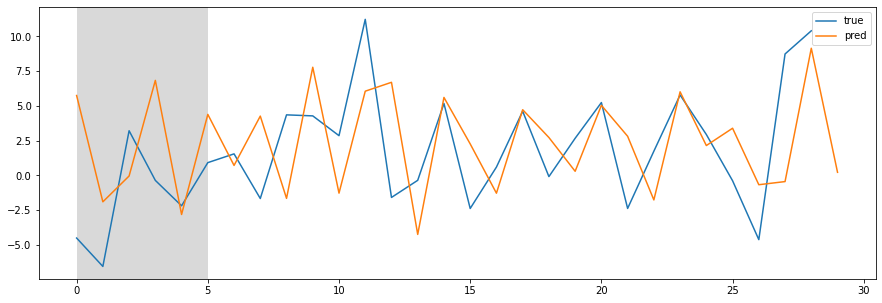

last day with actual price is: 2021-02-23 at: 253.880005
close price for next day is predicted to be: [254.09915751]
(529, 1) (2530, 2)


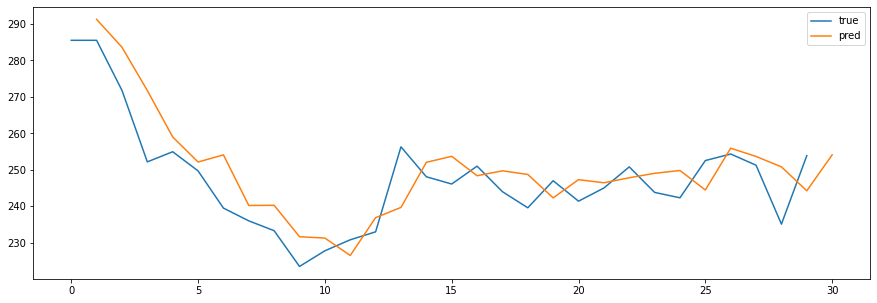

In [2096]:
#predict second day
new_day_targets = pred.copy()

new_day_x_data = pred.copy()
new_day_x_scaler = MinMaxScaler()
new_day_x_scaled = new_day_x_scaler.fit_transform(new_day_x_data)

new_day_targets = np.roll(new_day_targets, -days_shifted, axis=0)
new_day_y_data = new_day_targets[0:-days_shifted]
new_day_y_scaler = MinMaxScaler()
new_day_y_scaled = new_day_y_scaler.fit_transform(new_day_y_data)

predict_plot_compare(start_idx=2500, length=5000, x=new_day_x_scaled, y_true=new_day_y_data, 
                                  scaler=new_day_y_scaler, dates=dates, init_price=ms_init_price, 
                                  shift=days_shifted, filename=target_data_file)

print(true.shape, pred.shape)